# 2-State EEG Feature Extraction


## Importing all required libraries


In [1]:
import numpy as np
import pandas as pd
import os
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal
import librosa as lr
import librosa.feature as lrf
import sklearn as sk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

## Importing data

Open data (in Matlab format)

In [2]:
data_root = 'EEG Data/'

files = os.listdir(data_root)

mat = scipy.io.loadmat(data_root + files[1])

mat['o']['sampFreq'][0][0][0][0]

data = mat['o']['data'][0, 0]
FS = mat['o']['sampFreq'][0][0][0][0]

data


array([[ 32.,   0.,   0., ...,   0.,   0.,   0.],
       [ 33.,   0.,   0., ...,   0.,   0.,   0.],
       [ 34.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [123.,   0., 474., ...,   0.,   0.,   0.],
       [124.,   0., 459., ...,   0.,   0.,   0.],
       [125.,   0.,   0., ...,   0.,   0.,   0.]])

In [3]:
def feature_extraction(signal):
    n_mfcc = 5 
    feature_vector = []
    extracted_features = []
    # Timbral Texture Features
    feature_vector.append(lrf.spectral_centroid(signal)) # Spectral Centroid
    feature_vector.append(lrf.spectral_rolloff(signal)) # Rolloff
    feature_vector.append(lr.onset.onset_strength(signal)) # Flux
    feature_vector.append(lr.zero_crossings(signal)) # Zero Crossings
    for mfcc in lrf.mfcc(signal, n_mfcc=n_mfcc): # First 5 MFCCs
        feature_vector.append(mfcc)

    # Pitch Content Features
    n_mel = 10
    n_tonnetz = 6
    feature_vector.append(lr.beat.tempo(signal)) # Tempo
    
    for chroma in lrf.chroma_stft(signal, n_chroma=12): # First 5 MFCCs
        feature_vector.append(chroma)
        
    for mel in lr.power_to_db(lrf.melspectrogram(signal))[:n_mel, :] :
        feature_vector.append(mel)
    
    for tonal in lrf.tonnetz(signal)[:n_tonnetz, :] :
        feature_vector.append(tonal)
        
    for feature in feature_vector:
        extracted_features.append(np.mean(feature))
        extracted_features.append(np.std(feature)) 
        
    # Rhythymic Content Features
    peaks = -np.sort(-lr.onset.onset_strength(signal).flatten())
    A0 = peaks[0]
    A1 = peaks[1]
    RA = A1/A0    
    
    extracted_features.append(np.mean(lrf.tempogram(signal)))
    extracted_features.append(A0)
    extracted_features.append(A1)
    extracted_features.append(RA)
    
    return np.array(extracted_features)

Define channel names following the descripiton of the data set:

4-'EDAF3' 5-'EDF7'
6-'EDF3' 7-'EDFC5'
8-'EDT7' 9-'EDP7'
10-'EDO1' 11-'EDO2'
12-'EDP8' 13-'EDT8'
14-'EDFC6' 15-'EDF4'
16-'EDF8' 17-'EDAF4'

In [5]:
channel_indices = np.array(range(3, 17))
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
channel_map = dict(zip(channel_names, channel_indices))

In [19]:
channel_map

{'AF3': 3,
 'F7': 4,
 'F3': 5,
 'FC5': 6,
 'T7': 7,
 'P7': 8,
 'O1': 9,
 'O2': 10,
 'P8': 11,
 'T8': 12,
 'FC6': 13,
 'F4': 14,
 'F8': 15,
 'AF4': 16}

In [6]:
df = pd.DataFrame.from_dict(data)

Plot a single channel

Text(0, 0.5, 'EEG channel AF3')

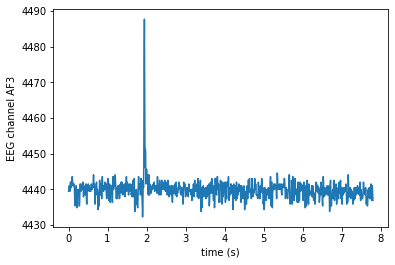

In [7]:
i_ch = 0
time = np.arange(1000) / FS
channel = data[:1000, channel_indices[i_ch]]
plt.plot(time, channel)
plt.xlabel('time (s)')
plt.ylabel(f'EEG channel {channel_names[i_ch]}')

## Extract features

Define states (according to the comments on the Data source).

The states seem to be defined arbitrarily as 10 min adjacent periods.

- 1st 10 minutes of data(t=0 min to t=10 min) is for "focussed" state
- 2nd 10 minutes of data(t=10 min to t=20 min) is for "unfocussed" state
- Remaining data(t=20 min to onwards) is for "Drowsed" state

In [8]:
states = {
 'focused': data[:FS * 10 * 60, :],
  'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
  'drowsy': data[FS * 30 * 60:, :],
}

Define frequency bands

In [9]:
def get_data(filename):
    mat = scipy.io.loadmat(os.path.join(data_root, filename))
    data = mat['o']['data'][0, 0]
    FS = mat['o']['sampFreq'][0][0][0][0]

    states = {
     'focused': data[:FS * 10 * 60, :],
      'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
      'drowsy': data[FS * 30 * 60:, :],
    }
    return states

Select subjects

In [10]:
# bunu degistirin
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34]

Extract EEG features -> mean powers in delta, alpha, beta, gamma frequency bands

In [23]:
# windowed processing
'''
rows_list = []
window_size = FS * 20 * 60
for subject_idx in subjects:
    states = get_data(f"eeg_record{subject_idx}.mat")
    for ch_name, ch_idx in channel_map.items():
        for state, eeg in states.items():
            data = eeg[:, ch_idx]
            for i in range(len(data) - window_size + 1):
                print("new window: ", window)
                window = data[i:i+window_size]
                powers = feature_extraction(window)
                rows_list.append(powers)
'''

# brute processing
rows_list = []
for subject_idx in subjects:
    states = get_data(f"eeg_record{subject_idx}.mat")
    for ch_name, ch_idx in channel_map.items():
        for state, eeg in states.items():
            data = eeg[:, ch_idx]
            print("new data: ", data)
            powers = feature_extraction(data)
            rows_list.append(powers)

new window:  [4440.         4438.97435897 4436.92307692 ... 4438.97435897 4442.05128205
 4442.56410256]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


new window:  [4437.94871795 4433.84615385 4433.84615385 ... 4440.51282051 4435.38461538
 4434.87179487]
new window:  [4433.84615385 4433.84615385 4436.92307692 ... 4435.38461538 4434.87179487
 4440.51282051]
new window:  [4433.84615385 4436.92307692 4439.48717949 ... 4434.87179487 4440.51282051
 4442.56410256]
new window:  [4436.92307692 4439.48717949 4437.94871795 ... 4440.51282051 4442.56410256
 4438.97435897]
new window:  [4439.48717949 4437.94871795 4437.43589744 ... 4442.56410256 4438.97435897
 4435.8974359 ]
new window:  [4437.94871795 4437.43589744 4437.94871795 ... 4438.97435897 4435.8974359
 4435.38461538]
new window:  [4437.43589744 4437.94871795 4437.94871795 ... 4435.8974359  4435.38461538
 4434.35897436]
new window:  [4437.94871795 4437.94871795 4438.97435897 ... 4435.38461538 4434.35897436
 4435.38461538]
new window:  [4437.94871795 4438.97435897 4440.         ... 4434.35897436 4435.38461538
 4438.97435897]
new window:  [4438.97435897 4440.         4438.97435897 ... 4435.

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame.from_dict(rows_list)

## Explore and export data

Save the features to CSV file

In [ ]:
#reads the data from the created csv
df.to_csv("eeg_features.csv")

In [39]:
df = pd.read_csv('eeg_features.csv')
df = df.drop('Unnamed: 0', axis=1)

In [40]:
X = df
#19th column is only 0.
X.pop('19')

#labels vector is set up this way to match the sizes.
y = pd.read_csv('labels.csv')
y = y['state']
y = pd.concat([y,y,y,y,y,y,y])
y = y.head(1428)
y = pd.DataFrame(y) # conver from pandas series to pandas df

Normalization and Standardization

In [17]:
#X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))*2-1
#X = (X - X.mean(axis=0)) / X.std(axis=0)

Test-Training Split

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
display_labels = ["focused","unfocused","drowsy"]

# apply normalization after splitting to avoid leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

PCA (0.999 explained variance)

In [42]:
# Encode the genre labels
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

y = y.reset_index(drop=True)

pca = PCA(n_components = 0.999)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
#X = dataPCA
variance = pd.DataFrame(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))


[3.94655155e-01 1.30632557e-01 8.76992021e-02 6.32969506e-02
 5.06519850e-02 3.98636066e-02 3.35480323e-02 2.59444318e-02
 1.65448023e-02 1.45560125e-02 1.30002685e-02 1.23090319e-02
 1.14522057e-02 9.44668926e-03 8.18686952e-03 7.25714547e-03
 6.43096763e-03 6.37093338e-03 5.85712915e-03 5.19798306e-03
 4.63254135e-03 4.13000829e-03 4.07179555e-03 3.72828363e-03
 3.44133881e-03 3.31517670e-03 3.10876236e-03 2.70951884e-03
 2.55574140e-03 2.45653887e-03 2.17132041e-03 2.08470169e-03
 1.84770286e-03 1.66301747e-03 1.60966551e-03 1.38030234e-03
 1.26089226e-03 1.08610827e-03 9.76204475e-04 7.85264146e-04
 7.44344513e-04 6.94422365e-04 6.91061508e-04 6.18638072e-04
 5.73004224e-04 5.04627061e-04 4.46057528e-04 3.85023367e-04
 3.62297847e-04 3.10421721e-04 2.91193205e-04 2.72390630e-04
 2.49947124e-04 2.21579807e-04 1.83178821e-04 1.80344932e-04
 1.68526949e-04 1.47998402e-04 1.34691836e-04]
0.9990965935987974


KNN Classifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.8161
Accuracy of K-NN classifier on test set: 0.6434


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNN Matrix


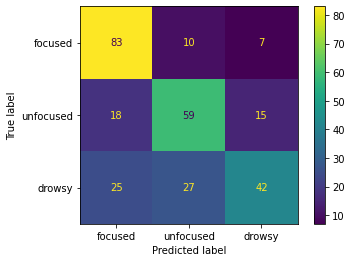

In [44]:
knn_cm = confusion_matrix(y_test, knn.predict(X_test))
knn_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm,display_labels=display_labels)
print("KNN Matrix")
knn_disp.plot()

Decision Tree Classifier

In [45]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.4f}'
     .format(dt.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.4f}'
     .format(dt.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.0000
Accuracy of Decision Tree classifier on test set: 0.5629


DT Matrix


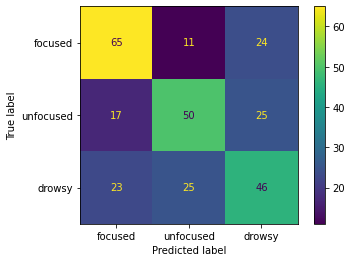

In [46]:
dt_cm = confusion_matrix(y_test, dt.predict(X_test))
dt_disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm,display_labels=display_labels)
print("DT Matrix")
dt_disp.plot()

Random Forest Classifier

In [679]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
print('Accuracy of RandomForestClassifier classifier on training set: {:.4f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of RandomForestClassifier classifier on test set: {:.4f}'
     .format(rf.score(X_test, y_test)))

/var/folders/4f/8lp82fhn6rj3fmpmwgsvbxf00000gn/T/ipykernel_11171/1193651153.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)


Accuracy of RandomForestClassifier classifier on training set: 1.0000
Accuracy of RandomForestClassifier classifier on test set: 0.7797


In [47]:
rf_cm = confusion_matrix(y_test, rf.predict(X_test))
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm,display_labels=display_labels)
print("DT Matrix")
rf_disp.plot()

NameError: name 'rf' is not defined

Logistic Regression Classifier

In [48]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.4f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.8301
Accuracy of Logistic regression classifier on test set: 0.7378


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


lr Matrix


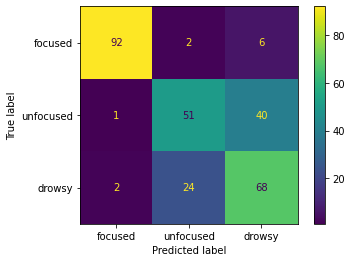

In [49]:
logreg_cm = confusion_matrix(y_test, logreg.predict(X_test))
logreg_disp = ConfusionMatrixDisplay(confusion_matrix=logreg_cm,display_labels=display_labels)
print("lr Matrix")
logreg_disp.plot()

SVM Classifier

In [50]:
from sklearn.svm import SVC
svm = SVC(C=1.0, kernel='linear', degree=10, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=1)
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.4f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.4f}'
     .format(svm.score(X_test, y_test)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of SVM classifier on training set: 0.8459
Accuracy of SVM classifier on test set: 0.7622


SVM Matrix


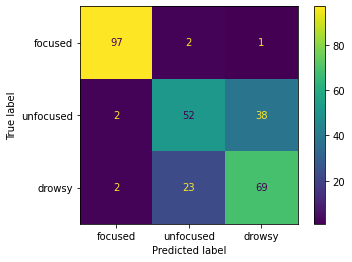

In [51]:
svm_cm = confusion_matrix(y_test, svm.predict(X_test))
display_labels = ["focused","unfocused",'drowsy']
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm,
                               display_labels=display_labels)
print("SVM Matrix")
svm_disp.plot()

Neural Network Classifier

In [52]:
import sklearn as sk
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(activation='logistic',solver='adam', alpha=1e-2, learning_rate='adaptive', max_iter=1000000, hidden_layer_sizes=(40), random_state=1)
NN.fit(X_train, y_train)
print('Accuracy of NN classifier on training set: {:.4f}'
     .format(NN.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.4f}'
     .format(NN.score(X_test, y_test)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of NN classifier on training set: 0.9982
Accuracy of NN classifier on test set: 0.7832


NN Matrix


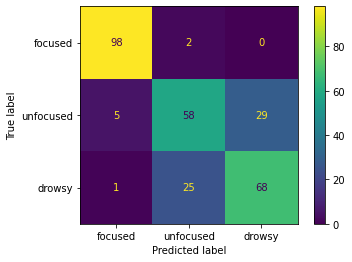

In [53]:
NN_cm = confusion_matrix(y_test, NN.predict(X_test))
NN_disp = ConfusionMatrixDisplay(confusion_matrix=NN_cm,display_labels=display_labels)
print("NN Matrix")
NN_disp.plot()

Gradient Boosting Classifier

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=1).fit(X_train, y_train)
print('Accuracy of GradientBoostingClassifier on training set: {:.4f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GradientBoostingClassifier on test set: {:.4f}'
     .format(clf.score(X_test, y_test)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of GradientBoostingClassifier on training set: 1.0000
Accuracy of GradientBoostingClassifier on test set: 0.6783


clf Matrix


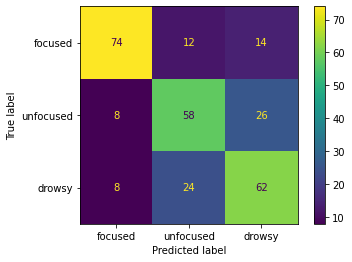

In [55]:
clf_cm = confusion_matrix(y_test, clf.predict(X_test))
clf_disp = ConfusionMatrixDisplay(confusion_matrix=clf_cm,display_labels=display_labels)
print("clf Matrix")
clf_disp.plot()

## Testing on another drowsiness dataset

In [23]:
mat_new = scipy.io.loadmat('/Users/kemalcankucuk/Biomedical Lab Work/Week 2/drowsiness-dataset.mat')

In [27]:
x_new = np.array(mat_new['EEGsample']) # 2022 EEG samples of size 20x384 
# a sample is 3 seconds of EEG data @ 128hz from 30 channels
y_new = np.array(mat_new['substate']) # labels, 0 for alert 1 for drowsy
sub_id = np.array(mat_new['subindex']) # subject index
y_new.astype(int)
sub_id.astype(int)

array([[ 1],
       [ 1],
       [ 1],
       ...,
       [11],
       [11],
       [11]])

In [31]:
channelnum=30
subjnum=11
samplelength=3
sf=128
samplenum=y_new.shape[0]

In [33]:
#   ydata contains the label of samples   
ydata=np.zeros(samplenum,dtype=np.longlong)

for i in range(samplenum):
    ydata[i]=y_new[i]

In [34]:
selectedchan=[28]
    
x_new = x_new[:,selectedchan,:]
channelnum = len(selectedchan)

In [36]:
from sklearn.neighbors import KNeighborsClassifier
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(x_new, ydata)))

ValueError: Found array with dim 3. Estimator expected <= 2.